1.Loading the data

In [2]:
from keras.datasets import cifar10
from keras.utils import np_utils
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image

In [3]:
#load the data
(X_train,y_train),(X_test,y_test)=cifar10.load_data()

In [4]:
#view characteristics
print("Training Images:{}".format(X_train.shape))
print("Test Images:{}".format(X_test.shape))

Training Images:(50000, 32, 32, 3)
Test Images:(10000, 32, 32, 3)


In [5]:
#single image
print(X_train[0].shape)

(32, 32, 3)


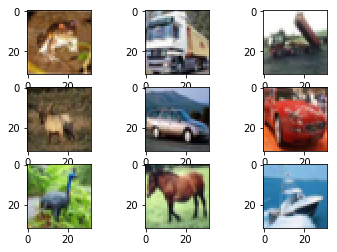

In [6]:
#create a 3x3 grid of images
for i in range(9):
    plt.subplot(330+1+i)   #every iteration 3x3 subplot position 0,1,2,....
    img=X_train[i]
    plt.imshow(img)
plt.show()

In [7]:
#prepocessing data

#fix random seed for reproducibility
seed=6
np.random.seed(seed)

#load the data
(X_train,y_train),(X_test,y_test)=cifar10.load_data()

#normalize the inputs from 0-255 to 0.0 to 1.0 -float
X_train=X_train.astype('float32')
X_test=X_test.astype('float32')

X_train/=255.0
X_test/=255.0

In [8]:
print(X_train[0])

[[[0.23137255 0.24313726 0.24705882]
  [0.16862746 0.18039216 0.1764706 ]
  [0.19607843 0.1882353  0.16862746]
  ...
  [0.61960787 0.5176471  0.42352942]
  [0.59607846 0.49019608 0.4       ]
  [0.5803922  0.4862745  0.40392157]]

 [[0.0627451  0.07843138 0.07843138]
  [0.         0.         0.        ]
  [0.07058824 0.03137255 0.        ]
  ...
  [0.48235294 0.34509805 0.21568628]
  [0.46666667 0.3254902  0.19607843]
  [0.47843137 0.34117648 0.22352941]]

 [[0.09803922 0.09411765 0.08235294]
  [0.0627451  0.02745098 0.        ]
  [0.19215687 0.10588235 0.03137255]
  ...
  [0.4627451  0.32941177 0.19607843]
  [0.47058824 0.32941177 0.19607843]
  [0.42745098 0.28627452 0.16470589]]

 ...

 [[0.8156863  0.6666667  0.3764706 ]
  [0.7882353  0.6        0.13333334]
  [0.7764706  0.6313726  0.10196079]
  ...
  [0.627451   0.52156866 0.27450982]
  [0.21960784 0.12156863 0.02745098]
  [0.20784314 0.13333334 0.07843138]]

 [[0.7058824  0.54509807 0.3764706 ]
  [0.6784314  0.48235294 0.16470589]


In [9]:
#class labels shape
print(y_train.shape)
print(y_train[0])   #i.e. output shows that y_train[0] has image belongs to class with label 6

(50000, 1)
[6]


In [10]:
#[6]=[0,0,0,0,0,0,6,0,0,0]--one hot vector

#hot encode outputs
Y_train=np_utils.to_categorical(y_train)
Y_test=np_utils.to_categorical(y_test)

num_of_classes=Y_test.shape[1]
print(num_of_classes)
print(Y_train.shape)
print(Y_train[0])

#10 classes are present


10
(50000, 10)
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


Building the ALL-CNN #research paper


The All-CNN Model-C

* Input 32 × 32 RGB image
* 3 × 3 conv. 96 ReLU
* 3 × 3 conv. 96 ReLU
* 3 x 3 max-pooling stride 2
* 3 × 3 conv. 192 ReLU
* 3 × 3 conv. 192 ReLU
* 3 × 3 max-pooling stride 2
* 3 × 3 conv. 192 ReLU
* 1 × 1 conv. 192 ReLU
* 1 × 1 conv. 10 ReLU
* global averaging over 6 × 6 spatial dimensions
* 10 or 100-way softmax

In [11]:
#import necessary libraries
from keras.models import Sequential     #i.e. add the layers one after another
from keras.layers import Dropout,Activation,Conv2D,GlobalAveragePooling2D        #dropout for regularization and prevent overfitting
from keras.optimizers import SGD


In [19]:
#define the model function

def allcnn(weights=None):
    
    #define model type=Sequential
    model=Sequential()
    
    #add model layers from above features of AllCNN
    model.add(Conv2D(96,(3,3),padding='same',input_shape=(32,32,3)))  #input
    model.add(Activation('relu'))
    model.add(Conv2D(96,(3,3),padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(96,(3,3),padding='same',strides=(2,2)))
    model.add(Dropout(0.5))   #randomly drop neurons and generalises the network better on data
    
    model.add(Conv2D(192,(3,3),padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(192,(3,3),padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(192,(3,3),padding='same',strides=(2,2)))
    model.add(Dropout(0.5))
    
    model.add(Conv2D(192,(3,3),padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(192,(1,1),padding='valid'))
    model.add(Activation('relu'))
    model.add(Conv2D(10,(1,1),padding='valid'))
    
    #add global average pooling layer with softmax
    model.add(GlobalAveragePooling2D())
    model.add(Activation('softmax'))
    
    #load the weights
    if weights:
        model.load_weights(weights)
    #return model
    return model

In [21]:
#define hyper parameters
learning_rate=0.01  #how quickly we should update weights
weight_decay=1e-6   #improves generalisation
momentum=0.9  

#we can also do parameter grid search to find the optimal hyperparameters

#build model
model=allcnn()

#define optimizers and compile model
sgd=SGD(lr=learning_rate,decay=weight_decay,momentum=momentum,nesterov=True)
model.compile(loss='categorical_crossentropy',optimizer=sgd,metrics=['accuracy'])  #loss is this as we categorised the objects and we want accuracy check

#print model summary
print(model.summary())

#define additional training parameters
epochs=350    #reqires 10 hours n gpu version!!!!
batch_size=32

#fit the model
model.fit(X_train,Y_train, validation_data=(X_test,Y_test), epochs=epochs, batch_size=batch_size, verbose=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_32 (Conv2D)           (None, 32, 32, 96)        2688      
_________________________________________________________________
activation_25 (Activation)   (None, 32, 32, 96)        0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 32, 32, 96)        83040     
_________________________________________________________________
activation_26 (Activation)   (None, 32, 32, 96)        0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 16, 16, 96)        83040     
_________________________________________________________________
dropout_8 (Dropout)          (None, 16, 16, 96)        0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 16, 16, 192)       166080    
__________

KeyboardInterrupt: 

In [22]:
#define hyper parameters
learning_rate=0.01  #how quickly we should update weights
weight_decay=1e-6   #improves generalisation
momentum=0.9  

#build model and define weights
weights='all_cnn_weights_0.9088_0.4994.hdf5'         #pre-trained weights
model=allcnn(weights)

#define optimizers and compile model
sgd=SGD(lr=learning_rate,decay=weight_decay,momentum=momentum,nesterov=True)
model.compile(loss='categorical_crossentropy',optimizer=sgd,metrics=['accuracy'])  #loss is this as we categorised the objects and we want accuracy check

#print model summary
print(model.summary())

#test the model
scores=model.evaluate(X_test,Y_test,verbose=1)
print('Accuracy:{}'.format(scores[1]))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_41 (Conv2D)           (None, 32, 32, 96)        2688      
_________________________________________________________________
activation_32 (Activation)   (None, 32, 32, 96)        0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 32, 32, 96)        83040     
_________________________________________________________________
activation_33 (Activation)   (None, 32, 32, 96)        0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 16, 16, 96)        83040     
_________________________________________________________________
dropout_10 (Dropout)         (None, 16, 16, 96)        0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 16, 16, 192)       166080    
__________

In [23]:
#can perform data augmentation to increase accuracy

In [24]:
#make dictionary of class labels and names
classes=range(10)

names=['airplane',
       'automobile',
       'bird',
       'cat',
       'deer',
       'dog',
       'frog',
       'horse',
       'ship',
       'truck']

In [25]:
#zip the names and classes to make a dictionary of class labels
class_labels=dict(zip(classes,names))
print(class_labels)


{0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}


In [39]:
#generate a batch of 9 images to predict
batch=X_test[100:109]
labels=np.argmax(Y_test[100:109],axis=-1)

#make predictions
predictions=model.predict(batch,verbose=1)

9/9 [==============================] - 0s 4ms/step


In [40]:
#print predictions
print(predictions)

[[4.56472342e-18 1.05810246e-20 1.89232421e-10 2.14114854e-11
  9.99999285e-01 2.80375247e-07 3.14786662e-13 4.23812452e-07
  1.36995572e-19 1.20971122e-18]
 [2.11912264e-16 2.03867016e-17 1.56727065e-09 5.35816639e-07
  1.62562644e-10 9.99999404e-01 1.67125547e-09 2.07823074e-08
  3.65486119e-15 3.51288651e-16]
 [1.27203225e-30 5.02736423e-28 5.15396277e-24 3.60512695e-21
  1.08752228e-27 8.15215322e-22 1.00000000e+00 1.10509080e-27
  6.19246192e-32 1.22743333e-23]
 [1.51438294e-16 4.76690539e-18 2.25836949e-09 1.00000000e+00
  4.34811284e-11 1.68841135e-12 4.53171246e-13 2.66869536e-16
  7.26597001e-19 6.20504176e-17]
 [8.24998297e-36 1.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 9.35651890e-36
  8.68659706e-30 8.21906932e-22]
 [5.96992736e-24 1.00000000e+00 7.54846902e-27 8.02280708e-27
  1.97139506e-30 2.73385063e-29 7.21873855e-31 5.56797325e-27
  1.61868680e-26 1.19061282e-13]
 [6.45635478e-18 2.96424244e-20 1.00464758e-11 9.99999881e

In [41]:
#these are class probabilities,sum should be 1
for image in predictions:
    print(np.sum(image))

1.0
0.99999994
1.0
1.0
1.0
1.0
1.0
1.0
1.0


In [42]:
#use np.argmax() to convert class probabilities to class labels
class_result=np.argmax(predictions,axis=-1)
print(class_result)

[4 5 6 3 1 1 3 6 8]


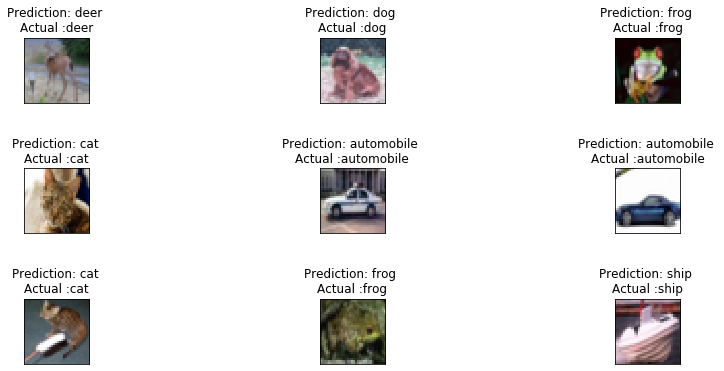

In [43]:
#let's create a grid of images to check predictions
fig,axs=plt.subplots(3,3,figsize=(15,6))
fig.subplots_adjust(hspace=1)

axs=axs.flatten()

for i,img in enumerate(batch):
    
    #determine label for each prediction,set title
    for key,value in class_labels.items():
        if class_result[i]==key:
            title='Prediction: {} \nActual :{}'.format(class_labels[key],class_labels[labels[i]])
            axs[i].set_title(title)
            axs[i].axes.get_xaxis().set_visible(False)
            axs[i].axes.get_yaxis().set_visible(False)
        
    #plot the image
    axs[i].imshow(img)
        
#show the plot
plt.show()
            
            